In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import csv
import numpy as np
import pandas as pd
import gensim
from sklearn.model_selection import train_test_split
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Preprocessing

###  Download datasets, split and filter

In [0]:
train_set, eval_set = train_test_split(pd.read_csv('train.txt', sep='\t', usecols=['gold_label', 'sentence1', 'sentence2']))
test_set = pd.read_csv('test.txt', sep='\t', usecols=['gold_label', 'sentence1', 'sentence2'])

train_set[train_set['gold_label'] == '-'][:10]

,gold_label,sentence1,sentence2
91197,-,"Two young girls, one in sunglasses, play with ...","Two little girls, one wearing sunglasses, are ..."
76830,-,a man in a striped blue shirt and a balloon ha...,The man is creative.
91515,-,small child playing in grass near sprinklers.,A small child runs through the sprinklers
94431,-,A man puts his hand to his head on a rock wall.,The man is climbing.
86985,-,A young boy using a pencil to draw on a piece ...,some boys have pencils
37279,-,bicycle race on a small street that curves rig...,A fast bike race on a small street.
108820,-,Zebra stripes in front of a red building.,Zebra colored stripes next to a building.
107159,-,A boy wearing a red shirt jumps off the blue s...,A boy slide off from a slide.
82472,-,Woman in red kneels to help sitting bride put ...,the woman is white
102213,-,A brown and white dog is licking a dog that lo...,A dog is cleaning another dog.


In [0]:
train_set = train_set[train_set['gold_label'] != '-'].apply(lambda s: s.str.lower()).applymap(gensim.parsing.preprocessing.strip_punctuation)
eval_set = eval_set[eval_set['gold_label'] != '-'].apply(lambda s: s.str.lower()).applymap(gensim.parsing.preprocessing.strip_punctuation)
test_set = test_set[test_set['gold_label'] != '-'].apply(lambda s: s.str.lower()).applymap(gensim.parsing.preprocessing.strip_punctuation)

train_set

,gold_label,sentence1,sentence2
64399,entailment,old man with white hair and white t shirt look...,there is a piece of art near the man with whit...
46928,neutral,man works one a computer with a cat in the bac...,a man is working on a computer while his cat n...
82599,entailment,a baby or young child is holding mixer in a bo...,a very young child is using a bowl
42828,entailment,a female chinese volleyball player looking int...,volleyball match at 2008 olympics
14669,entailment,a male skateboarder is skating in a vandalized...,a skateboarder is skating at the skate park
...,...,...,...
72773,entailment,the girl wearing the pink and white shirt and ...,girl wearing shorts jumping in the sand
27629,entailment,a girl in a purple shirt sits between two girl...,the girls are at the theater
90881,contradiction,a man playing the bagpipes in traditional garb...,yoda s robe is paisley
67764,contradiction,a man wearing a gray coat black hat and glove...,the man wearing clothes is sitting on top of a...


In [0]:
glove = pd.read_csv('glove.6B.200d.txt', header=None, delim_whitespace=True, quoting=csv.QUOTE_NONE)
glove

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200
0,the,-0.071549,0.093459,0.023738,-0.090339,0.056123,0.325470,-0.39796,-0.092139,0.061181,-0.189500,0.130610,0.143490,0.011479,0.381580,0.540300,-0.140880,0.243150,0.230360,-0.553390,0.048154,0.456620,3.23380,0.020199,0.049019,-0.014132,0.076017,-0.115270,0.200600,-0.077657,0.243280,0.163680,-0.341180,-0.066070,0.101520,0.038232,-0.176680,-0.88153,-0.338950,-0.035481,...,-0.042910,-0.067897,-0.293320,0.109780,-0.045365,0.232220,-0.311340,-0.289830,-0.666870,0.53097,0.194610,0.366700,0.261850,-0.651870,0.102660,0.113630,-0.129530,-0.682460,-0.187510,0.147600,1.076500,-0.229080,-0.009343,-0.206510,-0.352250,-0.267200,-0.003431,0.259060,0.217590,0.661580,0.121800,0.19957,-0.203030,0.344740,-0.243280,0.131390,-0.008877,0.336170,0.030591,0.255770
1,",",0.176510,0.292080,-0.002077,-0.375230,0.004914,0.239790,-0.28893,-0.014643,-0.109930,0.155920,0.206270,0.476750,0.099907,-0.140580,0.211140,0.121260,-0.318310,-0.089433,-0.090553,-0.319620,0.213190,2.48440,-0.077521,-0.084279,0.201860,0.260840,-0.404110,-0.191270,0.247150,0.223940,-0.063437,0.203790,-0.184630,-0.088413,0.024169,-0.287690,-0.61246,-0.126830,-0.088273,...,0.026823,-0.045444,-0.226420,-0.199770,-0.121380,0.169410,0.061998,0.426310,-0.088383,0.45756,0.077774,0.061342,0.457100,-0.177870,-0.145970,0.326540,0.002443,-0.118860,0.100810,-0.020011,1.036600,-0.398140,-0.681800,0.236850,-0.203960,-0.176680,-0.313850,0.148340,-0.052187,0.061300,-0.325820,0.19153,-0.154690,-0.146790,0.046971,0.032325,-0.220060,-0.207740,-0.231890,-0.108140
2,.,0.122890,0.580370,-0.069635,-0.502880,0.105030,0.399450,-0.38635,-0.084279,0.122190,0.080312,0.323370,0.475790,-0.038375,-0.007090,0.415240,0.321210,-0.211850,0.361440,-0.055623,-0.030512,0.428540,2.85470,-0.146230,-0.175570,0.311970,-0.131180,0.033298,0.130930,0.089889,-0.124170,0.002340,-0.068954,-0.107540,-0.115510,-0.310520,-0.120970,-0.46691,-0.083600,-0.037664,...,0.075441,0.082116,-0.460080,0.012393,-0.025310,0.141770,-0.092192,0.345050,-0.521360,0.57304,0.011973,0.033196,0.296720,-0.278990,0.199790,0.256660,0.082079,-0.078436,0.093719,0.242020,1.349500,-0.304340,-0.309360,0.420470,-0.079068,-0.148190,-0.089404,0.066800,0.224050,0.272260,-0.035236,0.17688,-0.053600,0.007003,-0.033006,-0.080021,-0.244510,-0.039174,-0.162360,-0.096652
3,of,0.052924,0.254270,0.313530,-0.356130,0.029629,0.510340,-0.10716,0.151950,0.057698,0.061490,0.061160,0.399110,-0.000290,0.319780,0.432570,-0.147080,0.054842,0.270790,-0.140510,-0.301010,0.163130,3.00130,0.222310,-0.142790,0.083705,0.089866,-0.527060,-0.089661,0.273110,0.314130,-0.040810,0.060557,-0.042656,0.241780,-0.291870,0.225750,-0.62980,-0.146410,-0.224290,...,0.405320,-0.027960,-0.133980,-0.110860,0.059506,0.240520,-0.597390,-0.002407,-0.185930,1.04200,-0.129690,0.208130,0.333050,-0.127800,0.085662,-0.076422,0.314070,-0.237840,-0.054838,0.011369,0.845000,-0.341650,0.093983,0.082445,-0.277770,-0.442260,-0.063078,0.372740,0.054468,0.241970,-0.040886,0.38940,-0.105090,0.233720,0.096027,-0.303240,0.244880,-0.086254,-0.419170,0.464960
4,to,0.573460,0.541700,-0.234770,-0.362400,0.403700,0.113860,-0.44933,-0.309910,-0.005341,0.584260,-0.025956,0.493930,-0.037209,-0.284280,0.097696,-0.489070,0.026027,0.376490,0.057788,-0.468070,0.081288,3.28250,-0.636900,0.379560,0.003817,0.093607,-0.128550,0.173800,0.105220,0.286480,0.210890,-0.470760,0.027733,-0.198030,0.076328,-0.846290,-0.79708,-0.387430,-0.030422,...,-0.124130,-0.344310,-0.232960,-0.211870,0.085387,0.070063,-0.198030,-0.026023,-0.390370,0.80002,0.405770,-0.079863,0.352630,-0.340430,0.396760,0.228620,-0.350280,-0.473440,0.597420,-0.116570,1.055200,-0.415700,-0.080552,-0.056571,-0.166220,0.192740,-0.095175,-0.207810,0.156200,0.050231,-0.279150,0.43742,-0.312370,0.131940,-0.332780,0

### Tokenize

In [0]:
text = ' '.join(train_set[['sentence1', 'sentence2']].stack())
words = pd.Series(gensim.utils.tokenize(text), name='words').drop_duplicates()
words

0                old
1                man
2               with
3              white
4               hair
             ...    
1675751      drinkgs
1675837    douchebag
1675867    interests
1676529       breezy
1676875         yoda
Name: words, Length: 18585, dtype: object

In [0]:
embeddings = glove.merge(words, how='inner', left_on=0, right_on=words.name).drop(columns=0).set_index('words')

embeddings.loc['<unk>'] = np.random.randn(200)
embeddings.loc['<bos>'] = np.random.randn(200)
embeddings.loc['<eos>'] = np.random.randn(200)
embeddings.loc['<pad>'] = np.random.randn(200)

embeddings

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200
words,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
the,-0.071549,0.093459,0.023738,-0.090339,0.056123,0.325470,-0.397960,-0.092139,0.061181,-0.189500,0.130610,0.143490,0.011479,0.381580,0.540300,-0.140880,0.243150,0.230360,-0.553390,0.048154,0.456620,3.233800,0.020199,0.049019,-0.014132,0.076017,-0.115270,0.200600,-0.077657,0.243280,0.163680,-0.341180,-0.066070,0.101520,0.038232,-0.176680,-0.881530,-0.338950,-0.035481,-0.550950,...,-0.042910,-0.067897,-0.293320,0.109780,-0.045365,0.232220,-0.311340,-0.289830,-0.666870,0.530970,0.194610,0.366700,0.261850,-0.651870,0.102660,0.113630,-0.129530,-0.682460,-0.187510,0.147600,1.076500,-0.229080,-0.009343,-0.206510,-0.352250,-0.267200,-0.003431,0.259060,0.217590,0.661580,0.121800,0.199570,-0.203030,0.344740,-0.243280,0.131390,-0.008877,0.336170,0.030591,0.255770
of,0.052924,0.254270,0.313530,-0.356130,0.029629,0.510340,-0.107160,0.151950,0.057698,0.061490,0.061160,0.399110,-0.000290,0.319780,0.432570,-0.147080,0.054842,0.270790,-0.140510,-0.301010,0.163130,3.001300,0.222310,-0.142790,0.083705,0.089866,-0.527060,-0.089661,0.273110,0.314130,-0.040810,0.060557,-0.042656,0.241780,-0.291870,0.225750,-0.629800,-0.146410,-0.224290,-0.056621,...,0.405320,-0.027960,-0.133980,-0.110860,0.059506,0.240520,-0.597390,-0.002407,-0.185930,1.042000,-0.129690,0.208130,0.333050,-0.127800,0.085662,-0.076422,0.314070,-0.237840,-0.054838,0.011369,0.845000,-0.341650,0.093983,0.082445,-0.277770,-0.442260,-0.063078,0.372740,0.054468,0.241970,-0.040886,0.389400,-0.105090,0.233720,0.096027,-0.303240,0.244880,-0.086254,-0.419170,0.464960
to,0.573460,0.541700,-0.234770,-0.362400,0.403700,0.113860,-0.449330,-0.309910,-0.005341,0.584260,-0.025956,0.493930,-0.037209,-0.284280,0.097696,-0.489070,0.026027,0.376490,0.057788,-0.468070,0.081288,3.282500,-0.636900,0.379560,0.003817,0.093607,-0.128550,0.173800,0.105220,0.286480,0.210890,-0.470760,0.027733,-0.198030,0.076328,-0.846290,-0.797080,-0.387430,-0.030422,-0.268490,...,-0.124130,-0.344310,-0.232960,-0.211870,0.085387,0.070063,-0.198030,-0.026023,-0.390370,0.800020,0.405770,-0.079863,0.352630,-0.340430,0.396760,0.228620,-0.350280,-0.473440,0.597420,-0.116570,1.055200,-0.415700,-0.080552,-0.056571,-0.166220,0.192740,-0.095175,-0.207810,0.156200,0.050231,-0.279150,0.437420,-0.312370,0.131940,-0.332780,0.188770,-0.234220,0.544180,-0.230690,0.349470
and,0.203270,0.473480,0.050877,0.002103,0.060547,0.330660,0.048486,0.021504,-0.536310,0.213120,0.199830,0.514080,0.000704,0.094641,0.068724,0.274240,-0.204930,0.232680,0.324900,-0.194440,0.646930,2.834200,0.140040,-0.268680,0.273250,0.015312,-0.279750,-0.264230,0.141830,-0.026064,0.113490,0.250390,-0.249720,-0.168820,-0.310390,-0.444580,-0.347890,-0.201810,-0.013405,0.236350,...,0.573390,0.180440,-0.117810,0.351620,0.162200,0.554830,0.140000,0.232100,-0.202050,0.602270,-0.153790,0.219070,0.284050,0.011906,0.106220,0.506700,-0.432010,-0.408870,-0.178190,0.220420,1.077500,-0.393810,-0.358280,0.363020,0.148720,0.035555,-0.030339,-0.112730,0.023382,0.159040,-0.143890,-0.117540,-0.636550,-0.121970,0.043809,0.147160,0.073750,-0.213580,-0.622490,0.143860
in,-0.102720,0.304100,-0.135770,-0.279790,-0.409260,-0.265530,0.104920,-0.044101,0.062731,-0.041600,0.355880,0.407570,-0.142950,-0.036534,0.425120,0.014823,0.000304,0.291500,-0.204160,-0.100390,0.307670,3.181500,0.045614,0.094457,0.255450,0.275280,-0.299390,0.045123,0.446810,0.015012,-0.107850,-0.389880,-0.205620,0.263060,-0.018163,-0.142440,-0.566100,-0.121680,0.287490,-0.305810,...,0.208250,-0.171630,-0.320250,-0.275370,-0.307740,0.181840,-0.026260,-0.062733,-0.436660,0.579540,-0.323480,-0.134570,0.385650,-0.301980,0.261970,-0.100340,-0.146000,-0.341700,0.166710,-0.235990,1

In [0]:
glove_words = embeddings.index
glove_words

Index(['the', 'of', 'to', 'and', 'in', 'a', 'for', 'that', 'on', 'is',
       ...
       'scandanavia', 'amongs', 'proctologist', 'spicket', 'pellam',
       'headress', '<unk>', '<bos>', '<eos>', '<pad>'],
      dtype='object', name='words', length=17074)

In [0]:
index_of_unknown = glove_words.get_loc('<unk>')
index_of_bos = glove_words.get_loc('<bos>')
index_of_eos = glove_words.get_loc('<eos>')
index_of_padding = glove_words.get_loc('<pad>')

### Map to indexes

In [0]:
def map_to_indexes(sentence):
    return pd.Series([index_of_bos] + [glove_words.get_loc(word) if word in glove_words else index_of_unknown for word in gensim.utils.simple_tokenize(sentence)] + [index_of_eos])

In [0]:
premise_train_set = train_set['sentence1'].apply(map_to_indexes).fillna(index_of_padding).astype(int)
hypothesis_train_set = train_set['sentence2'].apply(map_to_indexes).fillna(index_of_padding).astype(int)

premise_eval_set = eval_set['sentence1'].apply(map_to_indexes).fillna(index_of_padding).astype(int)
hypothesis_eval_set = eval_set['sentence2'].apply(map_to_indexes).fillna(index_of_padding).astype(int)

premise_test_set = test_set['sentence1'].apply(map_to_indexes).fillna(index_of_padding).astype(int)
hypothesis_test_set = test_set['sentence2'].apply(map_to_indexes).fillna(index_of_padding).astype(int)

premise_train_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
64399,17071,148,270,12,268,2430,3,268,1826,3714,758,17,5,4880,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
46928,17071,270,748,38,5,835,12,5,3913,4,0,1769,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
82599,17071,5,1880,36,413,847,9,1187,10346,4,5,1684,3,6123,0,4783,908,0,1684,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
42828,17071,5,1399,295,4941,580,758,61,0,1444,17,0,1266,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
14669,17071,5,1953,14276,9,4156,4,5,11606,6610,560,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72773,17071,0,1493,2260,0,3936,3,268,3714,3,6395,9,4684,4,0,3757,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
27629,17071,5,1493,4,5,5077,3714,4221,100,45,1644,4,467,4315,4,5,1890,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073
90881,17071,5,270,620,0,13418,4,1096,10824,1185,92,2772,117,5,4546,1823,438,17072,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,17073,

In [0]:
(premise_train_set == index_of_unknown).values.sum()

778

In [0]:
(hypothesis_train_set == index_of_unknown).values.sum()

1298

In [0]:
labels = train_set['gold_label'].unique()
labels

array(['entailment', 'neutral', 'contradiction'], dtype=object)

In [0]:
train_labels_indexes = train_set['gold_label'].apply(lambda x: np.argmax(labels == x))
eval_labels_indexes = eval_set['gold_label'].apply(lambda x: np.argmax(labels == x))
test_labels_indexes = test_set['gold_label'].apply(lambda x: np.argmax(labels == x))

train_labels_indexes

64399    0
46928    1
82599    0
42828    0
14669    0
        ..
72773    0
27629    0
90881    2
67764    2
87335    2
Name: gold_label, Length: 82398, dtype: int64

## Training

In [0]:
class Model(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, glove_vectors, tagset_size, pad_index):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.embeddings = nn.Embedding.from_pretrained(glove_vectors, freeze=True)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        self.out = nn.Sequential(
            nn.Dropout(p=.2),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, tagset_size)
        )

    def forward(self, premise, hypothesis):
        premise = self.embeddings(premise)
        hypothesis = self.embeddings(hypothesis)
        premise, _ = self.rnn(premise)
        hypothesis, _ = self.rnn(hypothesis)
        scores = self.out(torch.cat([premise[:, -1], hypothesis[:, -1]], 1))
        return scores


In [0]:
embedding_dim = 200
hidden_dim = 200
tagset_size = 3
batch_size = 32
epochs = 12
lr = 0.001
loss_function = nn.CrossEntropyLoss()

model = Model(embedding_dim, hidden_dim, torch.from_numpy(embeddings.to_numpy()).to(torch.float32).to(device), tagset_size, pad_index=glove_words.get_loc('<pad>')).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(train_labels_indexes.to_numpy()),
        torch.LongTensor(premise_train_set.to_numpy())[:, :10],
        torch.LongTensor(hypothesis_train_set.to_numpy())[:, :10]
    ),
    batch_size=batch_size
)

eval_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(eval_labels_indexes.to_numpy()),
        torch.LongTensor(premise_eval_set.to_numpy())[:, :10],
        torch.LongTensor(hypothesis_eval_set.to_numpy())[:, :10]
    ),
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(test_labels_indexes.to_numpy()),
        torch.LongTensor(premise_test_set.to_numpy())[:, :10],
        torch.LongTensor(hypothesis_test_set.to_numpy())[:, :10]
    ),
    batch_size=batch_size
)

model

Model(
  (embeddings): Embedding(17074, 200)
  (rnn): LSTM(200, 200, batch_first=True)
  (out): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=3, bias=True)
  )
)

In [0]:
class BestModelSerialize:
    def __init__(self, model_path, accuracy_path):
        self.model_path = model_path
        self.accuracy_path = accuracy_path
        try:
            self.best_model, self.best_accuracy = self.load_model()
        except FileNotFoundError:
            self.best_model = None
            self.best_accuracy = 0.
    
    def save_temporary(self, model, accuracy):
        if self.best_accuracy < accuracy:
            print(f'        ({accuracy:.3f} > {self.best_accuracy:.3f}) saving model')
            self.best_model = model
            self.best_accuracy = accuracy
    
    def save(self):
        torch.save(self.best_model, self.model_path)
        torch.save(torch.tensor(self.best_accuracy), self.accuracy_path)
    
    def load_model(self):
        return torch.load(self.model_path), torch.load(self.accuracy_path).item()

In [0]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, epochs, best_model_serialize):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def fit(self):
        for epoch in range(1, epochs+1):
            train_accuracy, loss = trainer.train()
            eval_accuracy = trainer.eval()
            scheduler.step()
            best_model_serialize.save_temporary(self.model, eval_accuracy)
            print(f'Epoch {epoch}/{epochs}: eval_acc = {eval_accuracy:.3f}, train_acc = {train_accuracy:.3f}, loss = {loss:.3f}')

    def train(self):
        self.model.train()

        loss_sum = 0.
        n_correct = 0
        n_total = 0

        for i, (targets, premise, hypothesis) in enumerate(self.train_loader):
            optimizer.zero_grad()
            scores = self.model(premise.to(device), hypothesis.to(device))
            
            loss = loss_function(scores, targets.to(device))
            
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            n_correct += (torch.argmax(scores, dim=1) == targets.to(device)).sum().item()
            n_total += len(targets)
        
        accuracy = 100. * n_correct / n_total
        self.losses.append(loss_sum)
        self.train_accuracies.append(accuracy)
        return accuracy, loss_sum
    
    def eval(self):
        self.model.eval()

        n_correct = 0
        n_total = 0
    
        with torch.no_grad():
            for targets, premise, hypothesis in self.test_loader:
                scores = self.model(premise.to(device), hypothesis.to(device))

                n_correct += (torch.argmax(scores, dim=1) == targets.to(device)).sum().item()
                n_total += len(targets)

        accuracy = 100. * n_correct / n_total
        self.eval_accuracies.append(accuracy)
        return accuracy

    def graph(self):
        plt.rcParams.update({'font.size': 12, 'xtick.color': 'white', 'ytick.color': 'white'})

        fig = plt.figure(figsize=[20, 8])
        ax1, ax2 = fig.subplots(1, 2, sharex=True)

        ax1.set_title('loss', color='white')
        ax1.set_xlabel('epoch')
        ax1.grid()
        
        ax1.plot(trainer.losses)
        ax1.scatter(range(self.epochs), trainer.losses)


        ax2.set_title('accuracy', color='white')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy (%)')
        ax2.set_ylim(0, 100)
        ax2.grid()

        ax2.plot(self.train_accuracies, label=f'train (max {max(self.train_accuracies):.3f} %)')
        ax2.scatter(range(self.epochs), self.train_accuracies)
        ax2.plot(self.eval_accuracies)
        ax2.scatter(range(self.epochs), self.eval_accuracies, label=f'eval (max {max(self.eval_accuracies):.3f} %)')

        ax2.legend()
        

In [0]:
best_model_serialize = BestModelSerialize('best_model', 'best_accuracy')

In [0]:
trainer = Trainer(model, train_loader, test_loader, epochs, best_model_serialize)

In [0]:
trainer.fit()

Epoch 1/12: eval_acc = 60.749, train_acc = 55.645, loss = 2385.046
Epoch 2/12: eval_acc = 63.314, train_acc = 62.667, loss = 2140.923
Epoch 3/12: eval_acc = 64.933, train_acc = 65.891, loss = 2006.559
Epoch 4/12: eval_acc = 66.450, train_acc = 69.727, loss = 1811.644
Epoch 5/12: eval_acc = 66.500, train_acc = 70.791, loss = 1763.934
Epoch 6/12: eval_acc = 66.877, train_acc = 71.649, loss = 1727.323
Epoch 7/12: eval_acc = 66.979, train_acc = 72.376, loss = 1690.601
Epoch 8/12: eval_acc = 67.101, train_acc = 72.488, loss = 1682.597
Epoch 9/12: eval_acc = 67.111, train_acc = 72.465, loss = 1675.083
Epoch 10/12: eval_acc = 67.152, train_acc = 72.598, loss = 1675.549
Epoch 11/12: eval_acc = 67.152, train_acc = 72.524, loss = 1673.971
Epoch 12/12: eval_acc = 67.182, train_acc = 72.567, loss = 1672.988


No handles with labels found to put in legend.


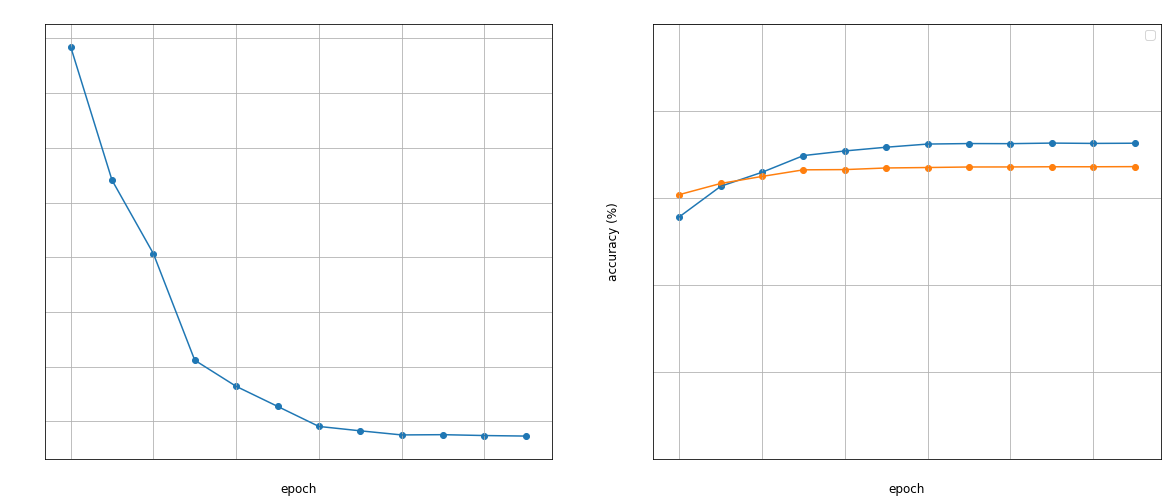

In [0]:
trainer.graph()

In [0]:
best_model_serialize.save()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dis

In [0]:
best_model, best_accuracy = best_model_serialize.load_model()
best_model

Model(
  (embeddings): Embedding(17074, 200)
  (rnn): LSTM(200, 200, batch_first=True)
  (out): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=200, out_features=3, bias=True)
  )
)

In [0]:
best_accuracy

67.45724487304688

In [0]:
n_correct = 0
n_total = 0

with torch.no_grad():
    for targets, premise, hypothesis in test_loader:
        scores = best_model(premise.to(device), hypothesis.to(device))

        n_correct += (torch.argmax(scores, dim=1) == targets.to(device)).sum().item()
        n_total += len(targets)

100. * n_correct / n_total

67.35545602605863